In [9]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

plt.style.use("seaborn-dark")
np.random.seed(42)

<ipython-input-9-9a201e339d8b>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-dark")


In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [12]:
data = pd.read_csv('voice.csv')
data.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [14]:
data.shape

(3168, 21)

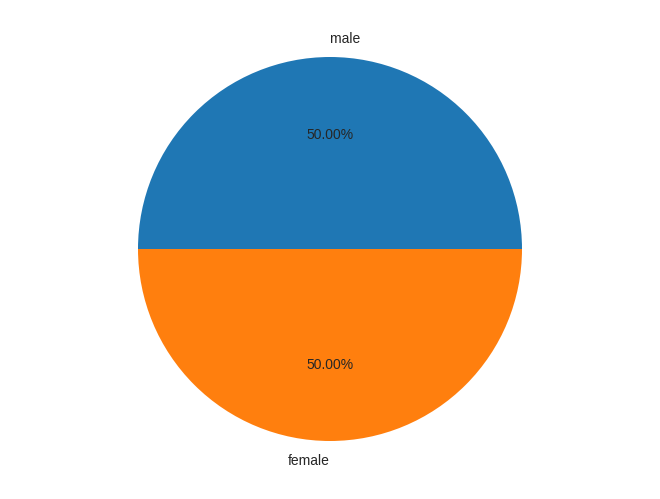

In [15]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')

labels = data['label'].unique()
target = data['label'].value_counts()
ax.pie(target, labels = labels,autopct='%1.2f%%')
plt.show()

In [16]:
data.columns


Index(['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt',
       'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx', 'label'],
      dtype='object')

In [17]:
def draw_corr(features):
    #Init
    corr_matrix = data[features].corr()
    tol = 0.7

    # correlation diagram creation
    def corr_tol(x):
        return x.apply(lambda x : True if (x >= tol or x <= -tol) else False)
    bool_corr_matrix = corr_matrix.apply(lambda x : corr_tol(x))

    for i in range(0,len(bool_corr_matrix)):
        bool_corr_matrix.iloc[i,i] = False

    bool_corr_matrix = pd.DataFrame(np.tril(bool_corr_matrix, k=0), 
                                    columns=bool_corr_matrix.columns, index=bool_corr_matrix.index)

    plt.figure(figsize=(10,5))
    plt.grid(True)
    sns_plot = sns.heatmap(bool_corr_matrix, square=True, cmap=sns.cubehelix_palette(8), linewidths=0.1)
    sns_plot.set_ylim(len(bool_corr_matrix)-1, -1)
    plt.show()


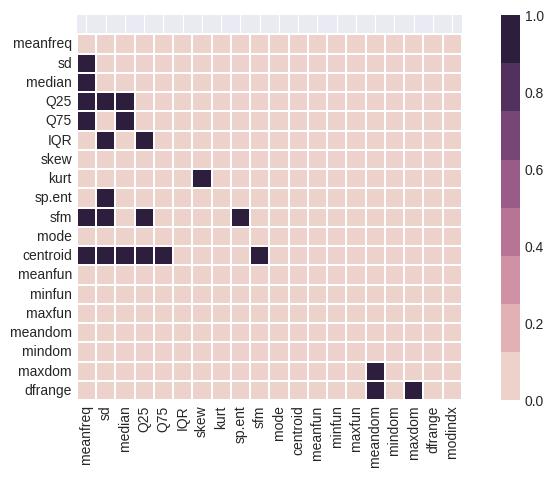

In [18]:
draw_corr(data.columns)

In [19]:
# Automatic field selection

corr_matrix = data.corr()

columns = np.full((corr_matrix.shape[0],), True, dtype=bool)
for i in range(corr_matrix.shape[0]):
    for j in range(i+1, corr_matrix.shape[0]):
        if corr_matrix.iloc[i,j] >= 0.8:
            if columns[j]:
                columns[j] = False

selected_columns = data.drop('label', axis=1).columns[columns]
selected_columns

Index(['meanfreq', 'sd', 'Q75', 'skew', 'sp.ent', 'mode', 'meanfun', 'minfun',
       'maxfun', 'meandom', 'mindom', 'modindx'],
      dtype='object')

In [20]:
features = ['meanfreq', 'skew', 'sp.ent', 'mode', 'meanfun', 'minfun',
       'maxfun', 'meandom', 'mindom', 'modindx']

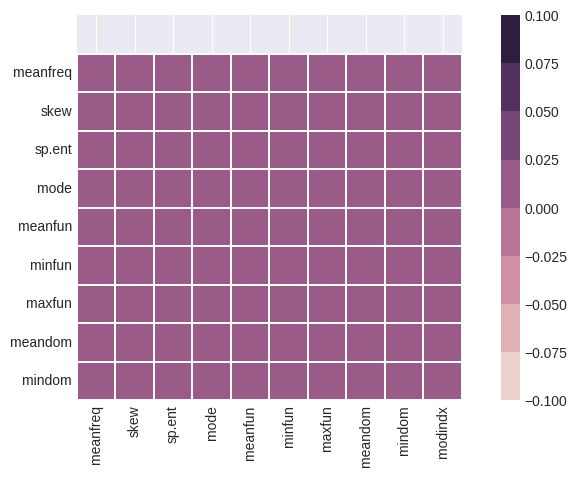

In [22]:
draw_corr(features)


In [23]:
X = data.loc[:, data.columns!='label']
y = data['label']


In [24]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y)
y = le.transform(y)
print(le.classes_)

['female' 'male']


In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =train_test_split(X, y,
                                                   stratify = y,
                                                   test_size = 0.20)

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

In [27]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=1)
lda_trans_df = lda.fit_transform(X_train, y_train)
X_train = pd.DataFrame(lda_trans_df)

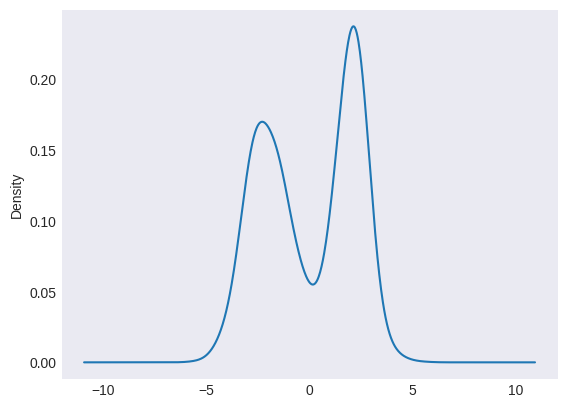

In [28]:
pd.DataFrame(X_train).plot.kde()
plt.legend("")

In [29]:
from sklearn.svm import SVC
clf = SVC()

#Init
model_for_cv = clf

from sklearn.model_selection import cross_val_score
scores = cross_val_score(model_for_cv, X_train, y_train, cv=5, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.97 (+/- 0.01)


In [30]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

model_for_cv = clf

from sklearn.model_selection import cross_val_score
scores = cross_val_score(model_for_cv, X_train, y_train, cv=5, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.95 (+/- 0.01)


In [31]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

model_for_cv = model

from sklearn.model_selection import cross_val_score
scores = cross_val_score(model_for_cv, X_train, y_train, cv=5, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.97 (+/- 0.01)


In [32]:
from sklearn.svm import SVC
clf = SVC(probability=True)
clf.fit(X_train, y_train)

SVC(probability=True)

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cm = confusion_matrix(y_test, y_pred)
print(cm)
print("----Classification Report----")
print(classification_report(y_test, y_pred))

[[309   8]
 [  6 311]]
----Classification Report----
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       317
           1       0.97      0.98      0.98       317

    accuracy                           0.98       634
   macro avg       0.98      0.98      0.98       634
weighted avg       0.98      0.98      0.98       634



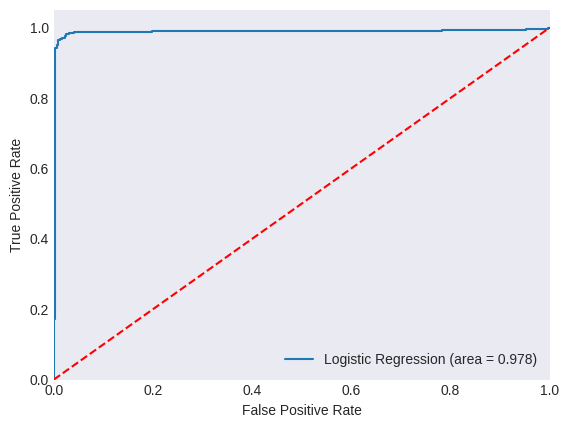

In [38]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.3f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()